In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("outdata.csv")
df['Game Date'] = pd.to_datetime(df['Game Date'])
df.head(2)

,Unnamed: 0,Season ID,Player ID,Player Name,Game ID,Game Date,Matchup,Player Team,Opponent,Home,...,Free Throws Attempt,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Player Efficiency Ratings
0,0,22020,1630173,Precious Achiuwa,22001069,2021-05-16,MIA @ DET,MIA,DET,0,...,7,3,7,0,2,1,2,3,23,23.112
1,1,22020,1630173,Precious Achiuwa,22001062,2021-05-15,MIA @ MIL,MIA,MIL,0,...,0,0,0,1,0,0,0,0,2,60.293


In [3]:
df.drop(["Unnamed: 0",
         "Player Name",
         "Season ID",
         "Player ID",
         "Game ID",
         "Matchup",
         "Game Date",
         "Player Team",
         "Opponent", 
         "Home",
         "Won",
         "Player Efficiency Ratings"], axis=1, inplace=True)

df.head(2)

,Minutes played,Field Goals Made,Field Goals Attempted,Field Goals 3 Points Made,Field Goal 3 Points Attempt,Free Throws Made,Free Throws Attempt,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points
0,42,10,16,0,0,3,7,3,7,0,2,1,2,3,23
1,2,1,2,0,1,0,0,0,0,1,0,0,0,0,2


In [4]:
df['DraftKings Score'] = df['Points']*1 + df['Field Goals 3 Points Made']*0.5 + df['Offensive Rebounds']*1.25 + df['Defensive Rebounds']*1.25 + df['Steals']*2 + df['Blocks']*2 + df['Turnovers']*(-0.5)
# We still need to include in this formula double-double and triple-double (we dont have it in the dataset)

df.head(2)

,Minutes played,Field Goals Made,Field Goals Attempted,Field Goals 3 Points Made,Field Goal 3 Points Attempt,Free Throws Made,Free Throws Attempt,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,DraftKings Score
0,42,10,16,0,0,3,7,3,7,0,2,1,2,3,23,40.5
1,2,1,2,0,1,0,0,0,0,1,0,0,0,0,2,2.0


In [5]:
# Using the current game stats to predict the next game DraftKing score
X = df.iloc[:-1, 0:-1].values
y = df.iloc[1:, -1].values

In [6]:
df.shape

(21349, 16)

In [7]:
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (21348, 15)
y.shape: (21348,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [9]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (17078, 15)
X_test.shape: (4270, 15)
y_train.shape: (17078,)
y_test.shape: (4270,)


In [10]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(0,1))
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (17078, 15)
X_test.shape: (4270, 15)
y_train.shape: (17078,)
y_test.shape: (4270,)


In [12]:
#X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f'X_train.shape: {X_train.shape}')

X_train.shape: (17078, 15, 1)


In [13]:
len(X_train[0])

15

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

#Adding the first LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a thrid LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

#adding the output layer
regressor.add(Dense(units = 1))

#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 10, verbose=1)

Epoch 1/100
1708/1708 [==============================] - 36s 18ms/step - loss: 166.2803
Epoch 2/100
1708/1708 [==============================] - 29s 17ms/step - loss: 113.2914
Epoch 3/100
1708/1708 [==============================] - 30s 18ms/step - loss: 103.5791
Epoch 4/100
1708/1708 [==============================] - 31s 18ms/step - loss: 101.3617
Epoch 5/100
1708/1708 [==============================] - 31s 18ms/step - loss: 100.2602
Epoch 6/100
1708/1708 [==============================] - 32s 19ms/step - loss: 99.5403
Epoch 7/100
1708/1708 [==============================] - 33s 19ms/step - loss: 98.0021
Epoch 8/100
1708/1708 [==============================] - 32s 19ms/step - loss: 96.8474
Epoch 9/100
1708/1708 [==============================] - 32s 19ms/step - loss: 96.1215
Epoch 10/100
1708/1708 [==============================] - 32s 19ms/step - loss: 96.6579
Epoch 11/100
1708/1708 [==============================] - 33s 19ms/step - loss: 96.0742
Epoch 12/100
1708/1708 [============

In [ ]:
# import pickle

# # Pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(history, f)

# # Unpickle
# with open('model.pkl', 'rb') as f:
#     history = pickle.load(f)

In [ ]:
# Save the model
# regressor.save('model')

# Load the model
# from tensorflow import keras
# history = keras.models.load_model('model')

In [16]:
y_pred = regressor.predict(X_test)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))
# We cannot use the classification report in a regression...

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

90.82178867584012

In [18]:
y_pred.shape

(4270, 1)

In [19]:
y_test.shape

(4270,)

In [20]:
y_pred.reshape(-1).shape

(4270,)

In [21]:
np.concatenate((y_test, y_pred.reshape(-1)), axis=0).shape

(8540,)

In [23]:
scatter_df = pd.DataFrame(np.concatenate((y_test, y_pred.reshape(-1)), axis=0), columns=['Value'])

real_predicted = ['Real Value'] * int(scatter_df.shape[0]/2) + ['Predicted Value'] * int(scatter_df.shape[0]/2)
scatter_df['Real/Predicted'] = real_predicted
scatter_df['Sample'] = list(range(int(scatter_df.shape[0]/2))) * 2
scatter_df.head(2)

,Value,Real/Predicted,Sample
0,8.25,Real Value,0
1,3.75,Real Value,1


<AxesSubplot:xlabel='Sample', ylabel='Value'>

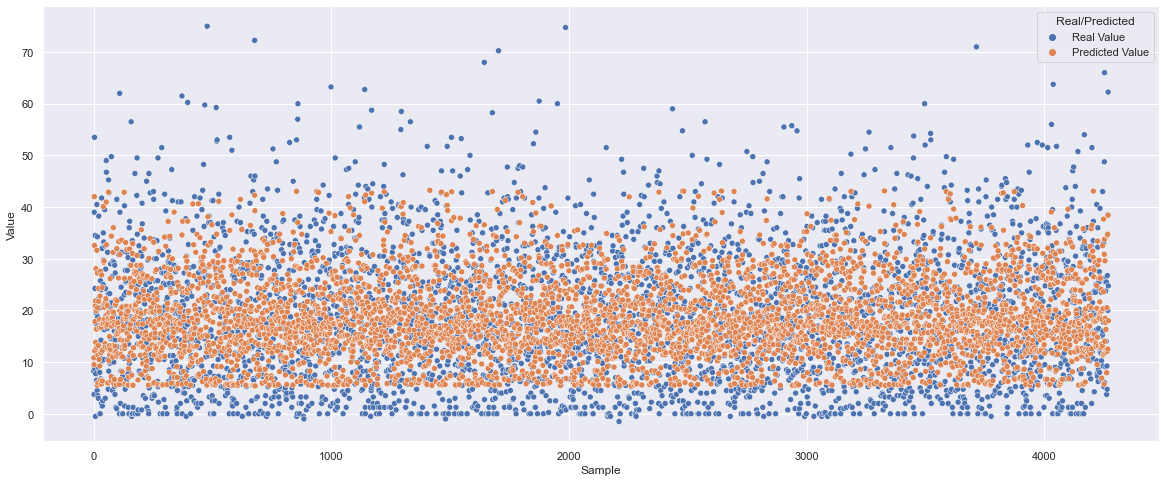

In [29]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 8)})
sns.scatterplot(data=scatter_df, x='Sample', y='Value', hue='Real/Predicted')

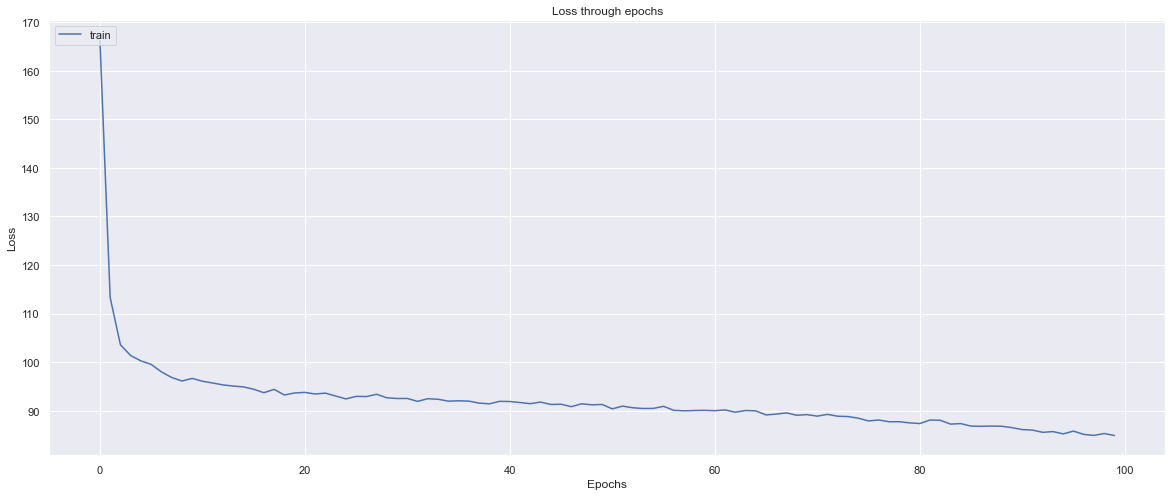

In [36]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.title('Loss through epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()